In [1]:
import json
import numpy as np
import pandas as pd
import models as m
import matplotlib.pyplot  as plt

from datetime import datetime as dt

pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
# Leer bicycle data a un dataframe
df = pd.read_json('data/bicycle_data.json').transpose().dropna()
# Crear columna para duración promedio del viaje
df['trip_length'] = df.apply(lambda row: (row.total_time / row.total_trips) / 60, axis=1)
df = df.sort_values(by='trip_length', ascending=False)

In [9]:
# Leer los viajes de las bicicletas que tienen números muy altos
trips = m.s.query(m.Trip).filter(
    m.Trip.bicycle_id==4667,
    m.Trip.departure_time >= dt(year=2016, month=5, day=13),
    m.Trip.departure_time <= dt(year=2017, month=5, day=26))
df2 = pd.read_sql(trips.statement, trips.session.bind).sort_values(by='departure_time')
# Crear columna de duracion de cada viaje
df2['trip_length'] = df2.apply(lambda row: (row['arrival_time'] - row['departure_time']).total_seconds(), axis=1)
df2.round(4)
df2.sort_values(by='departure_time', ascending=False)

,id,gender,age,bicycle_id,departure_station,departure_time,arrival_station,arrival_time,trip_length
9,41128127,M,61,4667,204,2016-05-14 20:02:35.000,224,2017-03-24 15:48:27.000,"27,114,352.00"
8,33071646,M,51,4667,213,2016-05-14 17:20:30.247,204,2016-05-14 17:34:57.157,866.91
7,33069610,M,44,4667,237,2016-05-14 15:20:00.507,213,2016-05-14 15:27:47.000,466.49
6,33061591,M,25,4667,116,2016-05-14 07:05:58.997,52,2016-05-14 07:15:15.000,556.00
5,33056977,M,30,4667,129,2016-05-13 19:46:02.117,116,2016-05-13 19:58:35.600,753.48
4,33056091,M,53,4667,63,2016-05-13 19:24:02.993,129,2016-05-13 19:33:26.000,563.01
3,33049300,M,28,4667,78,2016-05-13 16:44:42.643,63,2016-05-13 16:49:00.000,257.36
2,33047505,M,33,4667,79,2016-05-13 15:55:05.003,78,2016-05-13 15:58:08.917,183.91
1,33046656,M,39,4667,300,2016-05-13 15:34:22.947,79,2016-05-13 15:45:43.000,680.05
0,33045554,M,30,4667,337,2016-05-13 15:09:57.230,300,2016-05-13 15:15:03.000,305.77


In [3]:
# Encontrar los viajes que duran más de día y medio en las primeras 400 columnas
ids_2 = []
j = 0
for index, row in df.iterrows():
#     long_trips = False
    trips = m.s.query(m.Trip).filter_by(bicycle_id=int(index))
    df_temp = pd.read_sql(trips.statement, trips.session.bind)
    # Crear columna de duracion de cada viaje
    df_temp['trip_length'] = df_temp.apply(lambda row: (row['arrival_time'] - row['departure_time']).total_seconds(), axis=1)
    df_temp = df_temp.sort_values(by='trip_length', ascending=False)
    for i, r in df_temp.iterrows():
        if r['trip_length'] > 129600:
#             ids_2.append((r['id'], r['bicycle_id'], r['trip_length']))
            ids_2.append(r)
#             long_trips =True
        else:
            break
    if j >= 400:
        break
    j += 1
#     if not long_trips:
#         break
# ids_2

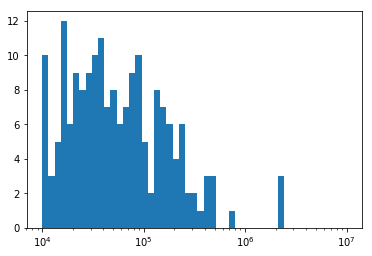

In [14]:
# Graficar la distribucion de los minutos de viaje
plt.hist([r.trip_length/60 for r in ids_2],
         bins=np.logspace(np.log10(10000),np.log10(10000000.0),50))
plt.gca().set_xscale("log")
len(m.s.query(m.Trip).filter(
    m.Trip.bicycle_id==int(viajes_anorm.iloc[0].bicycle_id),
    m.Trip.departure_time > viajes_anorm.iloc[0].departure_time,
    m.Trip.departure_time < viajes_anorm.iloc[0].arrival_time).all())plt.show()

In [18]:
def total_interm_trips(row):
    return len(m.s.query(m.Trip).filter(
        m.Trip.bicycle_id==int(row.bicycle_id),
        m.Trip.departure_time > row.departure_time,
        m.Trip.departure_time < row.arrival_time).all())

trips = pd.DataFrame(ids_2)
trips['viajes_entre_fechas'] = trips.apply(total_interm_trips, axis=1)
viajes_repar = trips[(trips.arrival_station > 452) | (trips.departure_station > 452)]
viajes_anorm = trips[(trips.arrival_station <= 452) & (trips.departure_station <= 452)]
viajes_anorm = viajes_anorm.sort_values(by='id', ascending=False)

In [20]:
writer = pd.ExcelWriter('data/output.xlsx')
trips.to_excel(writer,'Viajes mayores a 1.5 días')
viajes_repar.to_excel(writer, 'A estaciones de reparación')
viajes_anorm.to_excel(writer, 'Viajes anormales')
writer.save()

In [19]:
viajes_anorm.sort_values(by='trip_length', ascending=False)

,id,gender,age,bicycle_id,departure_station,departure_time,arrival_station,arrival_time,trip_length,viajes_entre_fechas
9467,31312696,M,29,395,36,2011-10-14 18:34:55.000,63,2016-03-06 02:27:40.000,"138,613,965.00",6956
7374,31312697,M,35,867,66,2011-10-14 18:41:48.913,63,2016-03-06 02:33:54.000,"138,613,925.09",5088
8682,31312695,M,65,865,84,2011-10-14 18:27:07.607,63,2016-03-06 02:14:49.000,"138,613,661.39",6449
1312,41128127,M,61,4667,204,2016-05-14 20:02:35.000,224,2017-03-24 15:48:27.000,"27,114,352.00",0
4281,27088107,F,31,2888,36,2014-12-12 08:47:04.560,273,2015-09-16 14:51:14.000,"24,041,049.44",0
1379,10374996,M,31,2162,84,2012-12-12 09:01:25.773,236,2013-09-13 16:08:17.000,"23,785,611.23",969
4932,7843418,M,48,1138,36,2012-09-16 17:58:21.077,96,2013-04-09 18:59:46.887,"17,715,685.81",717
3942,9516998,M,32,74,182,2013-01-27 08:39:42.453,182,2013-08-01 09:13:40.000,"16,072,437.55",0
5667,25933366,F,27,2722,194,2015-02-07 17:03:05.357,123,2015-08-03 22:10:11.803,"15,311,226.45",857
894,11183151,M,28,1963,175,2013-05-01 09:09:54.500,177,2013-10-22 01:04:48.000,"15,004,493.50",0
